In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import yaml
import phacsl.utils.formats.csv_tools as csv_tools
import os.path
from phacsl.utils.collections.phacollections import SingletonMetaClass
import pyrheautils
import random
from collections import deque, defaultdict
from policybase import TransferDestinationPolicy as BaseTransferDestinationPolicy
from facilitybase import CareTier, tierToQueueMap
from tools_util import readModelInputs, getFacDict
print 'loading model'
runDesc = '/home/welling/git/pyRHEA_github/src/sim/twoyear_allfac_ChicagoLand.yaml'
inputDict = readModelInputs(runDesc)
facDict = getFacDict(inputDict)


/home/welling/myEnv/local/lib/python2.7/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


loading model


In [2]:
failL = []
knownCounties = set()
countyD = {}
for abbrev, rec in facDict.items():
    if rec['category'] == 'COMMUNITY':
        continue
    addrWords = rec['address'].split(',')
    addrWords = [word.strip() for word in addrWords]
    county = None
    state = None
    for word in addrWords:
        if 'COUNTY' in word.upper() and not (word.upper().endswith('ROAD')  # 'county road'
                                             or word.upper().endswith('RD')):  # 'county rd'
            county = word.split()[0].upper()
        try:
            bits = word.split()
            zipcode = int(bits[-1])
            state = bits[0]
        except ValueError, e:
            pass
    if state is not None and county is not None:
        knownCounties.add((county, state))
        countyD[abbrev] = (county, state)
    else:
        failL.append(abbrev)
print 'failures: %s' % failL
print 'all counties: ', knownCounties


failures: []
all counties:  set([('KANKAKEE', 'IL'), ('LAKE', 'IN'), ('KENDALL', 'IL'), ('GRUNDY', 'IL'), ('JASPER', 'IN'), ('PORTER', 'IN'), ('DUPAGE', 'IL'), ('KENOSHA', 'WI'), ('NEWTON', 'IN'), ('DEKALB', 'IL'), ('WILL', 'IL'), ('KANE', 'IL'), ('LAPORTE', 'IN'), ('MCHENRY', 'IL'), ('COOK', 'IL'), ('LAKE', 'IL')])


In [3]:
inCounties = frozenset([('COOK', 'IL'), ('LAKE','IN'), ('PORTER', 'IN')])
inFacs = []
outFacs = []
outCounties = set()

for abbrev, coTuple in countyD.items():
    if coTuple in inCounties:
        inFacs.append(abbrev)
    else:
        outFacs.append(abbrev)
        outCounties.add(coTuple)
print 'outCounties: ', outCounties

outCounties:  set([('KANKAKEE', 'IL'), ('KENDALL', 'IL'), ('GRUNDY', 'IL'), ('JASPER', 'IN'), ('DUPAGE', 'IL'), ('KENOSHA', 'WI'), ('NEWTON', 'IN'), ('WILL', 'IL'), ('KANE', 'IL'), ('LAPORTE', 'IN'), ('MCHENRY', 'IL'), ('DEKALB', 'IL'), ('LAKE', 'IL')])


In [4]:
specialFacs = ['RML_5601_L']
for abbrev in specialFacs:
    outFacs.remove(abbrev)

In [5]:
inFacS = set(inFacs)
outFacS = set(outFacs)

In [6]:
mpzDir = '/home/welling/sshfshook/baseline'
selSumL = []
for idx, fname in enumerate(os.listdir(mpzDir)):
    if not fname.endswith('.mpz'):
        continue
    print 'loading %s' % fname
    df = pd.read_msgpack(os.path.join(mpzDir, fname))
    selDF = df[df['fac'].isin(inFacS)]
    selGrps = selDF.groupby(['tier', 'day'])
    selSums = selGrps.sum().add_suffix('_sum').reset_index()
    selSums['run'] = idx
    selSums['prevalence'] = selSums['COLONIZED_sum'].astype(float)/selSums['TOTAL_sum'].astype(float)
    selSumL.append(selSums)
selDF = pd.concat(selSumL)
print selDF

loading Chi_base_5y_3y_capped_1_2_proc_9_40577_0_1525472723.72.mpz
loading Chi_base_5y_3y_capped_1_2_proc_8_40578_0_1525472723.72.mpz
loading Chi_base_5y_3y_capped_1_2_proc_1_6110_0_1525472723.73.mpz
loading Chi_base_5y_3y_capped_1_2_proc_0_6109_0_1525472723.73.mpz
loading Chi_base_5y_3y_capped_1_2_proc_4_47905_0_1525472723.72.mpz
loading Chi_base_5y_3y_capped_1_2_proc_5_47904_0_1525472723.72.mpz
loading Chi_base_5y_3y_capped_1_2_proc_2_24503_0_1525472723.72.mpz
loading Chi_base_5y_3y_capped_1_2_proc_3_24502_0_1525472723.72.mpz
loading Chi_base_5y_3y_capped_1_2_proc_23_13949_0_1525672863.29.mpz
loading Chi_base_5y_3y_capped_1_2_proc_35_41204_0_1525672863.32.mpz
loading Chi_base_5y_3y_capped_1_2_proc_39_26431_0_1525672863.31.mpz
loading Chi_base_5y_3y_capped_1_2_proc_31_15737_0_1525672863.3.mpz
loading Chi_base_5y_3y_capped_1_2_proc_29_15735_0_1525672863.3.mpz
loading Chi_base_5y_3y_capped_1_2_proc_30_15734_0_1525672863.3.mpz
loading Chi_base_5y_3y_capped_1_2_proc_22_13951_0_1525672863.

In [7]:
print selDF['day'].max()

2921


In [8]:
baselineDF = selDF[selDF['day'] > 4*365]

In [9]:
mpzDir = '/home/welling/sshfshook/scen_1'
selSumL = []
for idx, fname in enumerate(os.listdir(mpzDir)):
    if not fname.endswith('.mpz'):
        continue
    print 'loading %s' % fname
    df = pd.read_msgpack(os.path.join(mpzDir, fname))
    selDF = df[df['fac'].isin(inFacS)]
    selGrps = selDF.groupby(['tier', 'day'])
    selSums = selGrps.sum().add_suffix('_sum').reset_index()
    selSums['run'] = idx
    selSums['prevalence'] = selSums['COLONIZED_sum'].astype(float)/selSums['TOTAL_sum'].astype(float)
    selSumL.append(selSums)
selDF = pd.concat(selSumL)
print selDF

loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_3_16955_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_7_11523_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_10_29534_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_9_29535_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_0_16958_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_4_11526_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_1_16957_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_8_29536_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_6_11524_0_1525679511.55.mpz
loading Chi_xdro_5y_3y_capped_1_2_capture_100_search_100_add_100_proc_5_11525_0_1525679511.55.mpz
loading Chi_xdro_5y

In [10]:
print selDF['day'].max()

2921


In [11]:
scen1DF = selDF[selDF['day'] > 4*365]

In [6]:
from plotting_utilities import pltCurvesWithBounds

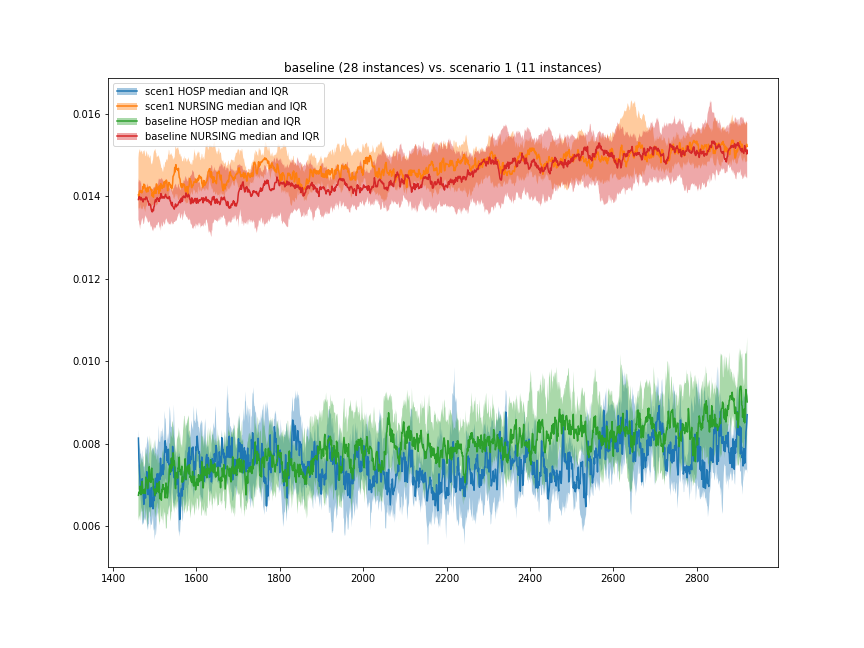

In [13]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]

fig, axes = plt.subplots(1, 1)
allArtists = []
allLabels = []
artistL, labelL = pltCurvesWithBounds(scen1DF, axes, 'prevalence', 'day', 'tier', ['HOSP', 'NURSING'],
                       ['scen1 HOSP', 'scen1 NURSING'])
allArtists += artistL
allLabels += labelL
artistL, labelL = pltCurvesWithBounds(baselineDF, axes, 'prevalence', 'day', 'tier', ['HOSP', 'NURSING'],
                       ['baseline HOSP', 'baseline NURSING'])
allArtists += artistL
allLabels += labelL
from matplotlib.legend_handler import HandlerTuple
axes.legend(allArtists, allLabels, handler_map={tuple: HandlerTuple()})
axes.set_title('baseline (28 instances) vs. scenario 1 (11 instances)')
#plt.savefig('/tmp/realitycheck.png')
plt.show()

In [7]:
fullDF = pd.read_msgpack('/home/welling/git/pyRHEA_github/src/sim/counts_output_dataframe.mpz')
print fullDF.columns
fullDF = fullDF[fullDF['abbrev'].isin(inFacS)]
fullGrps = fullDF.groupby(['tier', 'day', 'run'])
fullSums = fullGrps.sum().add_suffix('_sum').reset_index()
print fullSums.columns

Index([u'index', u'day', u'tier', u'xdroCPDays', u'abbrev', u'otherCPDays',
       u'CHRONIC', u'CLEAR', u'COLONIZED', u'INFECTED', u'RECOVERED',
       u'UNDETCOLONIZED', u'creArrivals', u'creBundlesHandedOut', u'arrivals',
       u'swabCPDays', u'contactPrecautionDays', u'newColonized',
       u'passiveCPDays', u'creSwabsUsed', u'newPatientsOnCP', u'run'],
      dtype='object')
Index([u'tier', u'day', u'run', u'index_sum', u'xdroCPDays_sum',
       u'otherCPDays_sum', u'CHRONIC_sum', u'CLEAR_sum', u'COLONIZED_sum',
       u'INFECTED_sum', u'RECOVERED_sum', u'UNDETCOLONIZED_sum',
       u'creArrivals_sum', u'creBundlesHandedOut_sum', u'arrivals_sum',
       u'swabCPDays_sum', u'contactPrecautionDays_sum', u'newColonized_sum',
       u'passiveCPDays_sum', u'creSwabsUsed_sum', u'newPatientsOnCP_sum'],
      dtype='object')


In [8]:
def computeConfidenceIntervals(df, fieldsOfInterest):
    """This is used via pd.Groupby.apply() to provide CIs for data columns"""
    rsltL = []
    rsltIdx = []
    for fld in fieldsOfInterest:
        print fld
        valV = df[fld]
        lo, hi = st.t.interval(0.95,len(valV)-1, loc=np.mean(valV),scale=st.sem(valV))
        rsltL.extend([lo, hi])
        rsltIdx.extend([fld+'_5%CI', fld+'_95%CI'])
    return pd.Series(rsltL, index=rsltIdx)


In [9]:
def addStatColumns(baseGp, fieldsOfInterest):
    """
    This creates a new DataFrame containing _median, _mean, _stdv, _Q1, _Q3, _5%CT, and _95%CT for
    each of the columns in fieldsOfInterest
    """
    statDF = baseGp.mean()
    dropL = [key + '_mean' for key in statDF.columns if key not in fieldsOfInterest]
    statDF = statDF.add_suffix('_mean').reset_index().drop(dropL, axis=1)
    suffix = '_median'
    df = baseGp.median().add_suffix(suffix).reset_index()
    kwargs = {st : df[st] for st in ['%s%s'% (fld, suffix) for fld in fieldsOfInterest]}
    statDF = statDF.assign(**kwargs)
    suffix = '_stdv'
    df = baseGp.std().add_suffix(suffix).reset_index()
    kwargs = {st : df[st] for st in ['%s%s'% (fld, suffix) for fld in fieldsOfInterest]}
    statDF = statDF.assign(**kwargs)
    suffix = '_Q1'
    df = baseGp.quantile(0.25).add_suffix(suffix).reset_index()
    kwargs = {st : df[st] for st in ['%s%s'% (fld, suffix) for fld in fieldsOfInterest]}
    statDF = statDF.assign(**kwargs)
    suffix = '_Q3'
    df = baseGp.quantile(0.75).add_suffix(suffix).reset_index()
    kwargs = {st : df[st] for st in ['%s%s'% (fld, suffix) for fld in fieldsOfInterest]}
    statDF = statDF.assign(**kwargs)
    df = baseGp.apply(computeConfidenceIntervals, fieldsOfInterest).reset_index()
    for suffix in ['_5%CI', '_95%CI']:
        kwargs = {st : df[st] for st in ['%s%s'% (fld, suffix) for fld in fieldsOfInterest]}
        statDF = statDF.assign(**kwargs)
    return statDF


In [10]:
idxL = ['day', 'tier', 'abbrev', 'run']
def getRemainingIndices(df):
    return [key for key in idxL if key in df.columns]

print getRemainingIndices(fullDF)
print getRemainingIndices(fullSums)

['day', 'tier', 'abbrev', 'run']
['day', 'tier', 'run']


In [11]:
print fullDF.columns

Index([u'index', u'day', u'tier', u'xdroCPDays', u'abbrev', u'otherCPDays',
       u'CHRONIC', u'CLEAR', u'COLONIZED', u'INFECTED', u'RECOVERED',
       u'UNDETCOLONIZED', u'creArrivals', u'creBundlesHandedOut', u'arrivals',
       u'swabCPDays', u'contactPrecautionDays', u'newColonized',
       u'passiveCPDays', u'creSwabsUsed', u'newPatientsOnCP', u'run'],
      dtype='object')


In [12]:
def addBedStats(df):
    cols = ['CLEAR', 'COLONIZED', 'CHRONIC', 'INFECTED', 'RECOVERED', 'UNDETCOLONIZED']
    return df.assign(colonizedDays=df['COLONIZED'], bedDays=df[cols].sum(axis=1))


In [13]:
sumDF = fullDF.groupby(['abbrev', 'day', 'run']).sum().reset_index()
sumDF = addBedStats(sumDF)
inCookDF = (sumDF[sumDF['abbrev'].isin(inFacs)].groupby(['day', 'run']).sum().reset_index())
sumSumDF = sumDF.groupby(['day', 'run']).sum().reset_index()
inCookDF = inCookDF.assign(prevalence=inCookDF['colonizedDays'].divide(inCookDF['bedDays']))
sumSumDF = sumDF.assign(prevalence=sumDF['colonizedDays'].divide(sumDF['bedDays']))

fieldsOfInterest = ['colonizedDays', 'bedDays', 'prevalence', 'newColonized', 'creArrivals']
sumSumStatDF = addStatColumns(sumSumDF.groupby(['day']), fieldsOfInterest)
inCookStatDF = addStatColumns(inCookDF.groupby(['day']), fieldsOfInterest)

colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays
bedDays
prevalence
newColonized
creArrivals
colonizedDays


In [14]:
print sumSumStatDF.columns
print inCookStatDF.columns

Index([u'day', u'creArrivals_mean', u'newColonized_mean', u'bedDays_mean',
       u'colonizedDays_mean', u'prevalence_mean', u'bedDays_median',
       u'colonizedDays_median', u'creArrivals_median', u'newColonized_median',
       u'prevalence_median', u'bedDays_stdv', u'colonizedDays_stdv',
       u'creArrivals_stdv', u'newColonized_stdv', u'prevalence_stdv',
       u'bedDays_Q1', u'colonizedDays_Q1', u'creArrivals_Q1',
       u'newColonized_Q1', u'prevalence_Q1', u'bedDays_Q3',
       u'colonizedDays_Q3', u'creArrivals_Q3', u'newColonized_Q3',
       u'prevalence_Q3', u'bedDays_5%CI', u'colonizedDays_5%CI',
       u'creArrivals_5%CI', u'newColonized_5%CI', u'prevalence_5%CI',
       u'bedDays_95%CI', u'colonizedDays_95%CI', u'creArrivals_95%CI',
       u'newColonized_95%CI', u'prevalence_95%CI'],
      dtype='object')
Index([u'day', u'creArrivals_mean', u'newColonized_mean', u'bedDays_mean',
       u'colonizedDays_mean', u'prevalence_mean', u'bedDays_median',
       u'colonizedDays_me

In [24]:
myAbbrevs = sumDF[sumDF['creBundlesHandedOut'] != 0]['abbrev']
print set(myAbbrevs)
s = set(['foo'])
s = s.union(myAbbrevs)
print s

set([])
set(['foo'])


In [27]:
df = pd.merge(sumSumStatDF, inCookStatDF, on=['day'], suffixes=['_regn', '_inCook'])
print df.columns

Index([u'day', u'creArrivals_mean_regn', u'newColonized_mean_regn',
       u'bedDays_mean_regn', u'colonizedDays_mean_regn',
       u'prevalence_mean_regn', u'bedDays_median_regn',
       u'colonizedDays_median_regn', u'creArrivals_median_regn',
       u'newColonized_median_regn', u'prevalence_median_regn',
       u'bedDays_stdv_regn', u'colonizedDays_stdv_regn',
       u'creArrivals_stdv_regn', u'newColonized_stdv_regn',
       u'prevalence_stdv_regn', u'bedDays_Q1_regn', u'colonizedDays_Q1_regn',
       u'creArrivals_Q1_regn', u'newColonized_Q1_regn', u'prevalence_Q1_regn',
       u'bedDays_Q3_regn', u'colonizedDays_Q3_regn', u'creArrivals_Q3_regn',
       u'newColonized_Q3_regn', u'prevalence_Q3_regn', u'bedDays_5%CI_regn',
       u'colonizedDays_5%CI_regn', u'creArrivals_5%CI_regn',
       u'newColonized_5%CI_regn', u'prevalence_5%CI_regn',
       u'bedDays_95%CI_regn', u'colonizedDays_95%CI_regn',
       u'creArrivals_95%CI_regn', u'newColonized_95%CI_regn',
       u'prevalence_95

In [28]:
fieldsOfInterest = ['foo', 'bar']
allFlds = []
for fld in fieldsOfInterest:
    allFlds.extend([fld + sfx for sfx in ['_regn', '_in13mi', '_out13mi', '_inCook', '_outCook',
                                              '_inTarget', '_outTarget']])
print allFlds

['foo_regn', 'foo_in13mi', 'foo_out13mi', 'foo_inCook', 'foo_outCook', 'foo_inTarget', 'foo_outTarget', 'bar_regn', 'bar_in13mi', 'bar_out13mi', 'bar_inCook', 'bar_outCook', 'bar_inTarget', 'bar_outTarget']


In [29]:
fullDF = pd.read_msgpack('/home/welling/git/pyRHEA_github/src/sim/my_fulldf.mpz')
print fullDF.columns

Index([u'abbrev', u'index_regn', u'xdroCPDays_regn', u'otherCPDays_regn',
       u'CHRONIC_regn', u'CLEAR_regn', u'COLONIZED_regn', u'INFECTED_regn',
       u'RECOVERED_regn', u'UNDETCOLONIZED_regn',
       ...
       u'arrivals_outTarget', u'swabCPDays_outTarget',
       u'contactPrecautionDays_outTarget', u'newColonized_outTarget',
       u'passiveCPDays_outTarget', u'creSwabsUsed_outTarget',
       u'newPatientsOnCP_outTarget', u'bedDays_outTarget',
       u'colonizedDays_outTarget', u'prevalence_outTarget'],
      dtype='object', length=150)


In [35]:
for word in fullDF.columns:
    if word.startswith('colonizedDays'):
        print word
    if word.endswith('_out13mi'):
        print word

colonizedDays_regn
colonizedDays_in13mi
colonizedDays
colonizedDays_inCook
colonizedDays_outCook
colonizedDays_inTarget
colonizedDays_outTarget


In [36]:
print fullDF['colonizedDays_regn']

Series([], Name: colonizedDays_regn, dtype: float64)


In [ ]:
headRow = ['Day']
headRowElts = ['Prev within 13','Prev outside 13','Prev within Cook','Prev outside Cook',
               'Prev target','Prev nonTarget','Prev regionWide',
               'Inc within 13','Inc outside 13','Inc within Cook','Inc outside Cook','Inc target',
               'Inc nonTarget','Inc regionWide']
entries = ['day']
entryElts = 7 * ['prevalence'] + 7 * ['newColonized']
entryDFs = [in13miDF, out13miDF, inCookDF, outCookDF, ]

In [67]:
#fullGrps = fullDF.groupby(['tier', 'run'])
#fullSums = fullGrps.sum().add_suffix('_sum').reset_index()
print fullDF.columns
#print fullDF['abbrev']
#print fullDF[fullDF['abbrev']=='ADAM_119_S']
newDF = fullDF.groupby(['abbrev','tier']).sum().reset_index()
print newDF['abbrev']
print newDF[newDF['abbrev']=='ALDE_1221_S']

Index([u'index', u'day', u'swabCPDays', u'tier', u'abbrev', u'otherCPDays',
       u'xdroCPDays', u'contactPrecautionDays', u'arrivals', u'creArrivals',
       u'creBundlesHandedOut', u'newColonized', u'CHRONIC', u'CLEAR',
       u'COLONIZED', u'INFECTED', u'RECOVERED', u'UNDETCOLONIZED',
       u'newPatientsOnCP', u'passiveCPDays', u'creSwabsUsed', u'run'],
      dtype='object')
0        ADAM_119_S
1       ADVE_5101_H
2       ADVE_5101_H
3       ADVO_1775_H
4       ADVO_1775_H
5      ADVO_17800_H
6      ADVO_17800_H
7       ADVO_2320_H
8       ADVO_2320_H
9       ADVO_3435_L
10      ADVO_4440_H
11      ADVO_4440_H
12       ADVO_836_H
13       ADVO_836_H
14      ALDE_1221_S
15      ALDE_1545_S
16     ALDE_16450_S
17       ALDE_201_S
18      ALDE_2520_S
19       ALDE_255_S
20      ALDE_4660_S
21       ALDE_504_S
22      ALDE_5050_S
23      ALDE_5831_S
24      ALDE_6120_S
25       ALDE_820_V
26       ALDE_820_V
27       ALDE_820_V
28       ALEX_800_H
29       ALEX_800_H
           ...   

In [95]:
dayOffset = 0
burninDays = 1825
scenarioWaitDays = 0

tsDF = fullDF
tsDF = tsDF[tsDF['day'] >= burninDays + scenarioWaitDays + dayOffset]  # clip date range
tsGpByTier = tsDF.groupby(['abbrev', 'tier', 'run'])
tsSumByTier = tsGpByTier.sum().add_suffix('_sum').reset_index()


In [96]:
from pathogenbase import PthStatus
cols = [st + '_sum' for st in PthStatus.names.values()]
print cols

['CLEAR_sum', 'COLONIZED_sum', 'CHRONIC_sum', 'INFECTED_sum', 'RECOVERED_sum', 'UNDETCOLONIZED_sum']


In [98]:
tierDF = tsSumByTier[['abbrev', 'tier', 'run']].copy()
print type(tierDF)
tierDF = tierDF.assign(colonizedDays=tsSumByTier['COLONIZED_sum'],
                       bedDays=tsSumByTier[cols].sum(axis=1))
tierDF = tierDF.assign(prevalence=tierDF['colonizedDays'].divide(tierDF['bedDays']))
print tierDF.columns

<class 'pandas.core.frame.DataFrame'>
Index([u'abbrev', u'tier', u'run', u'bedDays', u'colonizedDays',
       u'prevalence'],
      dtype='object')


In [107]:
tierGp = tierDF.groupby(['abbrev', 'tier'])
tierStatDF = tierGp.mean().add_suffix('_mean').reset_index().drop(['run_mean'], axis=1)
print tierStatDF.columns

Index([u'abbrev', u'tier', u'bedDays_mean', u'colonizedDays_mean',
       u'prevalence_mean'],
      dtype='object')


In [110]:
fieldsOfInterest = ['colonizedDays', 'bedDays', 'prevalence']
suffix = '_median'
df = tierGp.median().add_suffix(suffix).reset_index()
kwargs = {st : df[st] for st in ['%s%s'% (fld, suffix) for fld in fieldsOfInterest]}
tierStatDF = tierStatDF.assign(**kwargs)
suffix = '_stdv'
df = tierGp.std().add_suffix(suffix).reset_index()
kwargs = {st : df[st] for st in ['%s%s'% (fld, suffix) for fld in fieldsOfInterest]}
tierStatDF = tierStatDF.assign(**kwargs)
print tierStatDF.columns

Index([u'abbrev', u'tier', u'bedDays_mean', u'colonizedDays_mean',
       u'prevalence_mean', u'bedDays_median', u'colonizedDays_median',
       u'prevalence_median', u'bedDays_stdv', u'colonizedDays_stdv',
       u'prevalence_stdv'],
      dtype='object')


In [123]:
def myfun(x, fOI):
    return pd.Series([5.0, 7.0], index=['A', 'B'])
    #rslt = {}
    #for fld in fOI:
    #    rslt[fld] = sum(x[fld])
    #return pd.DataFrame(rslt, index=[0])
thing=tierGp.apply(myfun, fieldsOfInterest)
print '--------'
print thing
for gp in tierGp:
    print gp
    break

--------
                        A    B
abbrev       tier             
ADAM_119_S   NURSING  5.0  7.0
ADVE_5101_H  HOSP     5.0  7.0
             ICU      5.0  7.0
ADVO_1775_H  HOSP     5.0  7.0
             ICU      5.0  7.0
ADVO_17800_H HOSP     5.0  7.0
             ICU      5.0  7.0
ADVO_2320_H  HOSP     5.0  7.0
             ICU      5.0  7.0
ADVO_3435_L  LTAC     5.0  7.0
ADVO_4440_H  HOSP     5.0  7.0
             ICU      5.0  7.0
ADVO_836_H   HOSP     5.0  7.0
             ICU      5.0  7.0
ALDE_1221_S  NURSING  5.0  7.0
ALDE_1545_S  NURSING  5.0  7.0
ALDE_16450_S NURSING  5.0  7.0
ALDE_201_S   NURSING  5.0  7.0
ALDE_2520_S  NURSING  5.0  7.0
ALDE_255_S   NURSING  5.0  7.0
ALDE_4660_S  NURSING  5.0  7.0
ALDE_504_S   NURSING  5.0  7.0
ALDE_5050_S  NURSING  5.0  7.0
ALDE_5831_S  NURSING  5.0  7.0
ALDE_6120_S  NURSING  5.0  7.0
ALDE_820_V   NURSING  5.0  7.0
             SKILNRS  5.0  7.0
             VENT     5.0  7.0
ALEX_800_H   HOSP     5.0  7.0
             ICU      5.0  7.0

In [127]:
def computeConfidenceIntervals(df, fieldsOfInterest):
    """This is used via pd.Groupby.apply() to provide CIs for data columns"""
    rsltL = []
    rsltIdx = []
    for fld in fieldsOfInterest:
        valV = df[fld]
        lo, hi = st.t.interval(0.95,len(valV)-1, loc=np.mean(valV),scale=st.sem(valV))
        rsltL.extend([lo, hi])
        rsltIdx.extend([fld+'_5%CI', fld+'_95%CI'])
    return pd.Series(rsltL, index=rsltIdx)
thing = tierGp.apply(computeConfidenceIntervals, fieldsOfInterest)
print thing

                      colonizedDays_5%CI  colonizedDays_95%CI   bedDays_5%CI  \
abbrev       tier                                                              
ADAM_119_S   NURSING          -13.559307            24.559307   10812.365826   
ADVE_5101_H  HOSP           -5052.560383          6662.560383  167881.118419   
             ICU                     NaN                  NaN    1688.480818   
ADVO_1775_H  HOSP             420.120376          4841.879624  493396.888628   
             ICU             -125.948914           483.948914    2774.673322   
ADVO_17800_H HOSP            -300.094930          2546.094930  256935.357604   
             ICU             -255.389607           316.389607     850.673322   
ADVO_2320_H  HOSP            -400.852222          1860.852222  174518.244471   
             ICU             -821.140536           983.140536    1283.673322   
ADVO_3435_L  LTAC          -24539.343902         35027.343902    9707.035330   
ADVO_4440_H  HOSP           -4993.061362

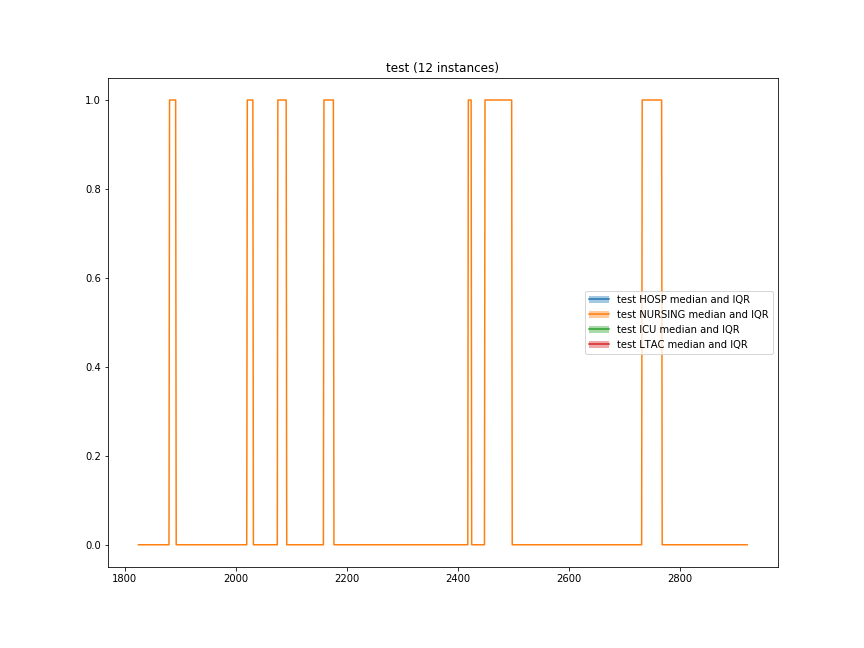

In [35]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]

fig, axes = plt.subplots(1, 1)
allArtists = []
allLabels = []
artistL, labelL = pltCurvesWithBounds(fullSums, axes, 'COLONIZED_sum', 'day', 'tier', ['HOSP', 'NURSING', 'ICU', 'LTAC'],
                       ['test HOSP', 'test NURSING', 'test ICU', 'test LTAC'])
allArtists += artistL
allLabels += labelL
from matplotlib.legend_handler import HandlerTuple
axes.legend(allArtists, allLabels, handler_map={tuple: HandlerTuple()})
axes.set_title('test (12 instances)')
#plt.savefig('/tmp/realitycheck.png')
plt.show()

In [ ]:
allSelGrps = selDF.groupby(['tier', 'day'])
allSelMedian = allSelGrps.median().reset_index()
allSelQ1 = allSelGrps.quantile(0.25).reset_index()
allSelQ3 = allSelGrps.quantile(0.75).reset_index()

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]

fig, axes = plt.subplots(1, 1)
for tier in ['HOSP', 'NURSING']:
    dayV = allSelMedian[allSelMedian['tier']==tier]['day']
    prevV = allSelMedian[allSelMedian['tier']==tier]['prevalence']
    axes.plot(dayV, prevV, '-', label='%s median' % tier)
    axes.fill_between(dayV,
                      allSelQ1[allSelQ1['tier']==tier]['prevalence'],
                      allSelQ3[allSelQ3['tier']==tier]['prevalence'],
                      alpha=0.4, label='%s IQR' % tier
                     )
plt.legend()
plt.title('Prevalence inside Chicago (30 instances)')
plt.savefig('/tmp/prev_inside_HOSP_NURSING.png')

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]

fig, axes = plt.subplots(1, 1)
for tier in ['SKILNRS', 'VENT']:
    dayV = allSelMedian[allSelMedian['tier']==tier]['day']
    prevV = allSelMedian[allSelMedian['tier']==tier]['prevalence']
    axes.plot(dayV, prevV, '-', label='%s median' % tier)
    axes.fill_between(dayV,
                      allSelQ1[allSelQ1['tier']==tier]['prevalence'],
                      allSelQ3[allSelQ3['tier']==tier]['prevalence'],
                      alpha=0.4, label='%s IQR' % tier
                     )
plt.legend()
plt.title('Prevalence inside Chicago (30 instances)')
plt.savefig('/tmp/prev_inside_SKILNRS_VENT.png')

In [ ]:
mpzDir = '/tmp/mpzfiles'
selSumL = []
for idx, fname in enumerate(os.listdir(mpzDir)):
    print 'loading %s' % fname
    df = pd.read_msgpack(os.path.join(mpzDir, fname))
    selDF = df[df['fac'].isin(outFacS)]
    selGrps = selDF.groupby(['tier', 'day'])
    selSums = selGrps.sum().add_suffix('_sum').reset_index()
    selSums['run'] = idx
    selSums['prevalence'] = selSums['COLONIZED_sum'].astype(float)/selSums['TOTAL_sum'].astype(float)
    selSumL.append(selSums)
selDF = pd.concat(selSumL)
print selDF

In [ ]:
selDF = selDF[selDF['day'] > 2*365]

In [ ]:
allSelGrps = selDF.groupby(['tier', 'day'])
allSelMedian = allSelGrps.median().reset_index()
allSelQ1 = allSelGrps.quantile(0.25).reset_index()
allSelQ3 = allSelGrps.quantile(0.75).reset_index()

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]

fig, axes = plt.subplots(1, 1)
for tier in ['HOSP', 'NURSING']:
    dayV = allSelMedian[allSelMedian['tier']==tier]['day']
    prevV = allSelMedian[allSelMedian['tier']==tier]['prevalence']
    axes.plot(dayV, prevV, '-', label='%s median' % tier)
    axes.fill_between(dayV,
                      allSelQ1[allSelQ1['tier']==tier]['prevalence'],
                      allSelQ3[allSelQ3['tier']==tier]['prevalence'],
                      alpha=0.4, label='%s IQR' % tier
                     )
plt.legend()
plt.title('Prevalence outside Chicago (30 instances, excludes RML_5601_L)')
plt.savefig('/tmp/prev_outside_HOSP_NURSING.png')

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]

fig, axes = plt.subplots(1, 1)
for tier in ['SKILNRS', 'VENT']:
    dayV = allSelMedian[allSelMedian['tier']==tier]['day']
    prevV = allSelMedian[allSelMedian['tier']==tier]['prevalence']
    axes.plot(dayV, prevV, '-', label='%s median' % tier)
    axes.fill_between(dayV,
                      allSelQ1[allSelQ1['tier']==tier]['prevalence'],
                      allSelQ3[allSelQ3['tier']==tier]['prevalence'],
                      alpha=0.4, label='%s IQR' % tier
                     )
plt.legend()
plt.title('Prevalence outside Chicago (30 instances, excludes RML_5601_L)')
plt.savefig('/tmp/prev_outside_SKILNRS_VENT.png')

242.35809451724998
90.25470327591734


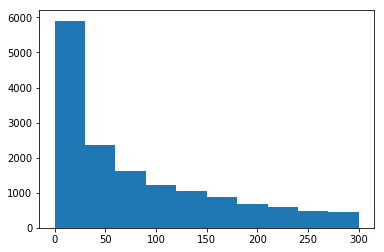

In [15]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
crv = weibull_min(0.607474246521175, scale=165.004828369412)
samps = crv.rvs(size=20000)
print samps.mean()
print crv.median()
fig, ax = plt.subplots(1,1)
ax.hist(samps, range=(0,300))
plt.show()

In [3]:
l = []
if isinstance(l, list):
    print 'true'


true
